# -----------------PROYECTO FINAL-----------------

## 1. IMPORTAR LIBRERIAS

In [29]:
from keras.src.saving.saving_api import load_model
import cv2
import mediapipe as mp
import numpy as np
import os
import tensorflow as tf
import sys
from collections import deque  
import math
from sklearn.model_selection import train_test_split

#graficos
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import io
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


## 2. INICIALIZAR MEDIAPIPE

In [30]:
# Configuración inicial global
mp_hands = mp.solutions.hands

# Optimizar MediaPipe
hands = mp_hands.Hands(
    static_image_mode=False,
    max_num_hands=2,
    min_detection_confidence=0.45,  # Reducir confianza
    min_tracking_confidence=0.45,
    model_complexity=0  # Menor complejidad
)

mp_draw = mp.solutions.drawing_utils

#VARIABLES GLOBALES 
MODEL_PATH = "model_quantized_90_pruebas_3.tflite"
NORMALIZATION_PARAMS_PATH = 'normalization_params_90_pruebas_3.npz'
dataset_dir = "dataset_11_90"
model_path = "gesture_model_me_10_90_pruebas_3.h5"
num_camara = 0

sequence_length = 90
total_landmarks = 126
gestures = []
X_mean = None
X_std = None

num_camara = 0

## 3. FUNCIONES PRINCIPALES

In [31]:
# Funciones principales
def init_system():
    global gestures
    os.makedirs(dataset_dir, exist_ok=True)
    gestures = get_existing_gestures()
    
def get_existing_gestures():
    return sorted([d for d in os.listdir(dataset_dir) if os.path.isdir(os.path.join(dataset_dir, d))])


## 4. DETECCION DE MANO

In [32]:
def detect_hands():
    print("\nIniciando detección de manos. Presiona 'ESC' para salir.")
    global num_camara
    cap = cv2.VideoCapture(num_camara)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        cv2.imshow("Detección de Manos", frame)
        if cv2.waitKey(1) & 0xFF == 27:
            break

    cap.release()
    cv2.destroyAllWindows()

## 5. RECOLLECION DE DATOS 

In [33]:
def collect_data():
    global gestures
    global num_camara
    gesture = input("\nIngrese la palabra o letra para la cual desea recolectar datos: ").upper()
    num_sequences = int(input("Ingrese el número de secuencias a capturar (recomendado: 50): "))
    
    save_dir = os.path.join(dataset_dir, gesture)
    os.makedirs(save_dir, exist_ok=True)

    print(f"\nRecolectando datos para el gesto '{gesture}'. Presiona 'ESC' para cancelar.")
    print("Mantenga la seña frente a la cámara...")
    
    cap = cv2.VideoCapture(num_camara)
    sequence = []
    counter = 0

    #NUEVO Configurar ventana de landmarks
    landmark_window_name = "Landmarks en Tiempo Real"
    cv2.namedWindow(landmark_window_name, cv2.WINDOW_NORMAL)
    cv2.resizeWindow(landmark_window_name, 640, 480)

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        #NUEVO Crear canvas para landmarks
        landmark_canvas = np.zeros((480, 640, 3), dtype=np.uint8)  # Canvas negro 640x480

        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)

        if results.multi_hand_landmarks:
            all_landmarks = []

            #NUEVO Dibujar landmarks en el canvas
            for hand_landmarks in results.multi_hand_landmarks:
                # Dibujar en el canvas negro
                mp_draw.draw_landmarks(
                    landmark_canvas,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    mp_draw.DrawingSpec(color=(0, 255, 0), thickness=2, circle_radius=2),
                    mp_draw.DrawingSpec(color=(0, 0, 255), thickness=2)
                )
            
            # Extraer coordenadas para el dataset
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    all_landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar si solo hay una mano
            if len(results.multi_hand_landmarks) < 2:
                all_landmarks += [0.0] * 63
            
            sequence.append(all_landmarks)

            # Dibujar en el frame original
            for hand_landmarks in results.multi_hand_landmarks:
                mp_draw.draw_landmarks(frame, hand_landmarks, mp_hands.HAND_CONNECTIONS)

        if len(sequence) == sequence_length:
            np.save(os.path.join(save_dir, f"secuencia_{counter}.npy"), sequence)
            counter += 1
            sequence = []
            print(f"Secuencias capturadas: {counter}/{num_sequences}")

        #NUEVO Mostrar información en ambas ventanas
        info_text = f"Secuencias: {counter}/{num_sequences}"
        cv2.putText(frame, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(landmark_canvas, info_text, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)


        cv2.imshow("Recolección de Datos", frame)
        #NEUVO
        cv2.imshow(landmark_window_name, landmark_canvas)
        if cv2.waitKey(1) & 0xFF == 27 or counter >= num_sequences:
            break

    cap.release()
    cv2.destroyAllWindows()
    gestures = get_existing_gestures()
    print(f"\nSe recolectaron {counter} secuencias para el gesto '{gesture}'")

## 6. CARGA DE DATOS

In [34]:
def custom_augmentation(sequence):
    """Aumentación 100% en TensorFlow"""
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.01)

    # Convertir explícitamente a float32
    sequence = tf.cast(sequence, tf.float32)
    # 1. Ruido Gaussiano
    noise = tf.random.normal(tf.shape(sequence), mean=0.0, stddev=0.01)
    sequence = tf.add(sequence, noise)
    
    # 2. Escalado aleatorio
    scale_factor = tf.random.uniform([], 0.95, 1.05)
    sequence = tf.multiply(sequence, scale_factor)
    
    # 3. Rotación 2D (versión TensorFlow)
    angle = tf.random.uniform([], -15.0, 15.0)  # Grados
    angle_rad = tf.math.divide(angle * math.pi, 180.0)
    
    # Crear matriz de rotación como tensor
    rot_matrix = tf.stack([
        [tf.cos(angle_rad), -tf.sin(angle_rad), 0.0],
        [tf.sin(angle_rad), tf.cos(angle_rad), 0.0],
        [0.0, 0.0, 1.0]
    ])
    
    # Aplicar rotación a cada landmark
    original_shape = tf.shape(sequence)
    sequence = tf.reshape(sequence, [-1, 3])  # [secuencia_length*42, 3]
    sequence = tf.matmul(sequence, rot_matrix)
    sequence = tf.reshape(sequence, original_shape)
    
    # 4. Desplazamiento temporal (versión TensorFlow)
    shift = tf.random.uniform([], -5, 5, dtype=tf.int32)
    sequence = tf.cond(
        tf.random.uniform([]) > 0.5,
        lambda: tf.roll(sequence, shift=shift, axis=0),
        lambda: sequence
    )

    
    return sequence


# Modificar la función create_dataset
def create_dataset(X_data, y_data, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((X_data, y_data))
    
    if augment:
        dataset = dataset.map(
            lambda x, y: (custom_augmentation(x), y),
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.shuffle(1000)
    
    return dataset.batch(32).prefetch(tf.data.AUTOTUNE)

In [35]:
def load_data(augment=True):
    X = []
    y = []
    
    for label_idx, gesture in enumerate(gestures):
        gesture_dir = os.path.join(dataset_dir, gesture)
        sequences = [f for f in os.listdir(gesture_dir) if f.endswith('.npy')]
        print(f"Gesto '{gesture}' - secuencias encontradas: {len(sequences)}")
        
        for seq_file in sequences:
            seq_path = os.path.join(gesture_dir, seq_file)
            sequence = np.load(seq_path)
            
            if sequence.shape == (sequence_length, total_landmarks):
                X.append(sequence)
                y.append(label_idx)
            else:
                print(f"Secuencia {seq_file} con forma {sequence.shape} ignorada.")
    
    return np.array(X, dtype=np.float32), np.array(y), gestures  # Asegurar tipo float32


## 7. ENTRENAMIENTO DEL MODELO

In [36]:
def train_model():
    global X_mean, X_std, gestures
    global NORMALIZATION_PARAMS_PATH, MODEL_PATH
    
    # 1. Verificar datos de entrenamiento
    gestures = get_existing_gestures()
    if not gestures:
        print("\nNo hay datos recolectados. Primero recolecte datos de gestos.")
        return

    # 2. Cargar y preparar datos
    print("\nCargando datos y preparando el entrenamiento...")
    X, y, gestures = load_data(augment=False)  # Cargar sin aumentación inicial
    y = tf.keras.utils.to_categorical(y)

    # 3. Dividir datos antes de crear el Dataset
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

    # 4. Calcular parámetros de normalización
    #X_mean = np.mean(X_train, axis=(0, 1)).astype(np.float32)
    #X_std = np.std(X_train, axis=(0, 1)).astype(np.float32)
    X_mean = np.mean(X_train, axis=(0)).astype(np.float32)
    X_std = np.std(X_train, axis=(0)).astype(np.float32)
    X_train = (X_train - X_mean) / X_std
    X_val = (X_val - X_mean) / X_std  # Aplicar misma normalización a validación

    train_dataset = create_dataset(X_train, y_train, augment=True)
    val_dataset = create_dataset(X_val, y_val, augment=False)
    

    # 4. Guardar parámetros de normalización
    np.savez(NORMALIZATION_PARAMS_PATH, mean=X_mean, std=X_std)
    
    # 5. Arquitectura optimizada del modelo
    # Modelo CNN + LSTM Bidireccional
    inputs = tf.keras.Input(shape=(sequence_length, total_landmarks))

    # Primera etapa CNN
    x = tf.keras.layers.Conv1D(64, 3, activation="relu", padding="same")(inputs)
    x = tf.keras.layers.MaxPooling1D(2)(x)  # Reduce secuencia a la mitad

    # Primera LSTM (retorna secuencia completa)
    x = tf.keras.layers.LSTM(64, return_sequences=True)(x)

    # Segunda etapa CNN
    x = tf.keras.layers.Conv1D(128, 3, activation="relu", padding="same")(x)
    x = tf.keras.layers.MaxPooling1D(2)(x)  # Reduce nuevamente

    # Segunda LSTM (retorna secuencia) + Tercera LSTM (solo último paso)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    x = tf.keras.layers.LSTM(64, return_sequences=False)(x)

    outputs = tf.keras.layers.Dense(len(gestures), activation="softmax")(x)

    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    """Explicación:
    CNN Inicial: Extrae patrones espaciales entre los landmarks en cada paso temporal.
    LSTM Intermedia: Procesa las características extraídas a lo largo del tiempo.
    CNN Profunda: Captura relaciones más complejas en las características temporales.
    LSTM Finales: Modelan dependencias temporales jerárquicas.
    Ventajas vs Opción LSTM Inicial:
    Las CNN actúan como filtros espaciales antes de las LSTM, reduciendo ruido y mejorando la eficiencia.
    Intercalar CNN entre LSTM permite capturar patrones locales en diferentes niveles de abstracción temporal.
    Evita el problema de que las LSTM iniciales procesen datos crudos sin características relevantes.
    Consideraciones:
    Usar return_sequences=True en LSTM intermedias para mantener la secuencia.
    Ajustar padding y MaxPooling para controlar la longitud de la secuencia.
    Si la secuencia es muy corta, eliminar MaxPooling en etapas posteriores.
    
    probar con 
    # Nueva arquitectura:
    inputs = Input(shape=(sequence_length, total_landmarks))
    x = Bidirectional(LSTM(128, return_sequences=True))(inputs)
    x = Attention()(x)  # Capa de atención para features clave
    x = Bidirectional(LSTM(64))(x)
    outputs = Dense(len(gestures), activation='softmax')(x)
    mejor """

    # 6. Compilación y entrenamiento
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    model.summary()

    # Calcular pesos con datos de entrenamiento
    y_train_true = np.argmax(y_train, axis=1)
    class_weights = compute_class_weight("balanced", classes=np.unique(y_train_true), y=y_train_true)
    class_weights = dict(enumerate(class_weights))

    print("\nIniciando entrenamiento...")
    history = model.fit(
        train_dataset,
        validation_data=val_dataset,  # Usar dataset de validación explícito
        class_weight=class_weights,  # Añadir este parámetro
        epochs=50,
        verbose=1
    )

     # Función para graficar métricas de entrenamiento
    def generate_training_plots(history):
        # Crear figura de 12x5 pulgadas (ancho x alto)
        plt.figure(figsize=(12, 5))
        
        # Primer subgráfico (1 fila, 2 columnas, posición 1)
        plt.subplot(1, 2, 1)
        # Graficar precisión de entrenamiento (datos del historial)
        plt.plot(history.history['accuracy'], label='Precisión Entrenamiento')
        # Graficar precisión de validación (línea punteada)
        plt.plot(history.history['val_accuracy'], '--', label='Precisión Validación')
        plt.title('Evolución de la Precisión')
        plt.ylabel('Precisión')  # Rango 0-1 (0% a 100%)
        plt.xlabel('Época')  # Iteración de entrenamiento
        plt.legend()  # Mostrar etiquetas
        plt.grid(True, linestyle='--', alpha=0.5)  # Cuadrícula suave

        # Segundo subgráfico (posición 2)
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Pérdida Entrenamiento')
        plt.plot(history.history['val_loss'], '--', label='Pérdida Validación')
        plt.title('Evolución de la Pérdida')
        plt.ylabel('Pérdida')  # Valor de la función de costo
        plt.xlabel('Época')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.5)

        # Ajustar espacios entre subgráficos
        plt.tight_layout()
        # Guardar como imagen PNG (calidad vectorial)
        plt.savefig('training_metrics.png', dpi=300, bbox_inches='tight')
        plt.show()  # Mostrar en pantalla

    # Función para matriz de confusión
    def generate_confusion_matrix(model, X_val, y_val, gestures):
        # Obtener etiquetas verdaderas (índices de mayor probabilidad)
        y_true = np.argmax(y_val, axis=1)
        # Predecir y obtener índices de clases
        y_pred = np.argmax(model.predict(X_val), axis=1)
        
        # Calcular matriz de confusión (formato numérico)
        cm = confusion_matrix(y_true, y_pred)
    
        # Crear figura para el heatmap
        plt.figure(figsize=(10, 8))
        # Heatmap con anotaciones numéricas
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=gestures,  # Nombres clases en X
                    yticklabels=gestures)  # Nombres clases en Y
        plt.title('Matriz de Confusión', pad=20)
        plt.xlabel('Predicciones del Modelo')
        plt.ylabel('Etiquetas Reales')
        # Rotar etiquetas X 45 grados para mejor legibilidad
        plt.xticks(rotation=45, ha='right')
        plt.yticks(rotation=0)
        # Ajustar márgenes
        plt.tight_layout()
        plt.show()
        plt.close()  # Cerrar figura


        # Reporte detallado de métricas
        print("\nReporte de Clasificación:")
        print(classification_report(y_true, y_pred, 
                                target_names=gestures,
                                digits=3))  # 3 decimales
 

    # 7. Guardar modelo y resultados
    model.save(model_path)
    generate_training_plots(history)
    #generate_confusion_matrix(model, X, y)
    generate_confusion_matrix(model, X_val, y_val, gestures)
    print(f"\nModelo guardado en {model_path}")
    
    # 8. Conversión a TFLite con configuraciones especiales
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.target_spec.supported_ops = [
        tf.lite.OpsSet.TFLITE_BUILTINS,
        tf.lite.OpsSet.SELECT_TF_OPS
    ]
    converter._experimental_lower_tensor_list_ops = False
    
    try:
        tflite_model = converter.convert()
        with open(MODEL_PATH, 'wb') as f:
            f.write(tflite_model)
        print("\nModelo TFLite exportado exitosamente")
    except Exception as e:
        print(f"\nError en conversión TFLite: {str(e)}")
    
    # Mostrar métricas finales
    val_accuracy = history.history['val_accuracy'][-1]
    print(f"Precisión de validación final: {val_accuracy:.2%}")

## TF LITE

In [37]:
def convert_to_tflite():
    global MODEL_PATH
    try:
        # Cargar el modelo entrenado
        model = tf.keras.models.load_model(model_path)
        
        # Configurar el conversor con parámetros especiales
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        
        # Añadir estas 3 líneas clave para compatibilidad con LSTM
        converter.target_spec.supported_ops = [
            tf.lite.OpsSet.TFLITE_BUILTINS,
            tf.lite.OpsSet.SELECT_TF_OPS
        ]
        converter._experimental_lower_tensor_list_ops = False
        converter.allow_custom_ops = True  # Permitir operaciones personalizadas
        
        # Realizar la conversión
        tflite_model = converter.convert()
        
        # Guardar el modelo cuantizado
        with open(MODEL_PATH, 'wb') as f:
            f.write(tflite_model)
            
        print("\n✅ Conversión a TFLite exitosa!")
        
    except Exception as e:
        print(f"\n❌ Error en conversión: {str(e)}")
        print("Posibles soluciones:")
        print("1. Verifique que el modelo .h5 existe")
        print("2. Actualice TensorFlow: pip install --upgrade tensorflow")
        print("3. Reinicie el runtime/kernel")

    global gestures
    gestures = get_existing_gestures()
    print("Gestos cargados para evaluación:", gestures)

    print("Salida del modelo:", model.output_shape)



def representative_dataset_gen():
    # Generador de datos de ejemplo para calibración
    for _ in range(100):
        yield [np.random.randn(1, sequence_length, total_landmarks).astype(np.float32)]

## 8. EVALUACION DEL MODELO

In [38]:
from threading import Thread
# -----------------PROYECTO FINAL - VERSIÓN MEJORADA-----------------
## 8. EVALUACION DEL MODELO (CORRECCIÓN CRÍTICA)
def evaluate():
    global MODEL_PATH, NORMALIZATION_PARAMS_PATH, num_camara
    global gestures
    gestures = get_existing_gestures()


    if not os.path.exists(MODEL_PATH):
        print("\n¡Primero debe entrenar y convertir el modelo!")
        return
    
    # 1. Cargar parámetros y modelo
    try:
        with np.load(NORMALIZATION_PARAMS_PATH) as data:
            X_mean = data['mean']
            X_std = data['std']
            
        interpreter = tf.lite.Interpreter(model_path=MODEL_PATH)
        interpreter.allocate_tensors()
        input_details = interpreter.get_input_details()[0]
        output_details = interpreter.get_output_details()[0]
        print("Output details shape:", output_details['shape'])
    except Exception as e:
        print(f"\nError crítico: {str(e)}")
        return

    
    # 2. Configuración de cámara
    cap = cv2.VideoCapture(num_camara)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 1280)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)

    #https://www.toolify.ai/es/ai-news-es/cmo-cambiar-la-resolucin-de-la-cmara-en-opencv-1149753 
    
    if not cap.isOpened():
        print("\n¡No se puede acceder a la cámara!")
        return

    # 3. Variables de estado mejoradas
    sequence = deque(maxlen=sequence_length)
    prediction_history = deque(maxlen=15)  # Suavizado de predicciones
    current_gesture = "Esperando..."
    current_confidence = 0.0

    # 4. Bucle principal optimizado
    while True:
        ret, frame = cap.read()
        if not ret:
            break

        #NUEVO Redimensionar el frame para la ventana (ejemplo: 640x360)
        frame_resized = cv2.resize(frame, (640,390))


        
        # Siempre procesar landmarks (manos detectadas o no)
        rgb_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = hands.process(rgb_frame)
        landmarks = []
        #NUEVO no esta en v2. Solo agregar landmarks si hay manos detectadas
        hand_detected = False  # Variable para saber si hay manos detectadas
        
        if results.multi_hand_landmarks:
            #NUEVO no esta en v2. Solo agregar landmarks si hay manos detectadas
            hand_detected = True  # Se detectaron manos
            # Extraer landmarks para ambas manos
            for hand in results.multi_hand_landmarks[:2]:
                for lm in hand.landmark:
                    landmarks.extend([lm.x, lm.y, lm.z])
            
            # Rellenar con ceros si es necesario
            if len(landmarks) < total_landmarks:
                landmarks += [0.0] * (total_landmarks - len(landmarks))
        #else:
            # Si no hay manos, usar ceros
            #landmarks = [0.0] * total_landmarks
    
        #NUEVO no esta en v2. Solo agregar landmarks si hay manos detectadas
        if hand_detected:
            sequence.append(landmarks)
            # Si se detectan manos nuevamente, borrar predicción anterior
            if current_gesture != "Esperando...":
                current_gesture = "Esperando..."
                current_confidence = 0.0
                prediction_history.clear()  # Vaciar historial de predicciones para evitar residuos
        
        # Realizar predicción cuando la secuencia esté completa
        if len(sequence) == sequence_length:
            try:
                # Preprocesamiento y normalización
                seq_array = np.array(sequence)
                seq_array = (seq_array - X_mean) / (X_std + 1e-7)
                input_data = seq_array.reshape(1, sequence_length, total_landmarks).astype(np.float32)

                
                # Durante la evaluación, agregar testeo de forma
                if input_data.shape != tuple(input_details['shape']):
                    print(f"Error: Forma esperada {input_details['shape']}, obtenida {input_data.shape}")
                    return
                
                # Inferencia
                interpreter.set_tensor(input_details['index'], input_data)
                interpreter.invoke()
                prediction = interpreter.get_tensor(output_details['index'])[0]
                
                # Procesar resultados con suavizado
                predicted_idx = np.argmax(prediction)
                confidence = prediction[predicted_idx]
                prediction_history.append((predicted_idx, confidence))
                
                # Calcular moda de las últimas predicciones
                most_common = max(prediction_history, key=lambda x: list(prediction_history).count(x))
                final_idx, final_confidence = most_common
                
                #if final_confidence > 0.9:
                #NUEVO Validación de índice dentro de rangos
                if 0 <= final_idx < len(gestures) and final_confidence > 0.9:
                    current_gesture = gestures[final_idx]
                    current_confidence = final_confidence
                    
            except Exception as e:
                print(f"Error en predicción: {str(e)}")



        #NUEVO no esta en v2 Si no se detectan manos, mantener el último gesto válido
        if not hand_detected:
            current_gesture = "Esperando..."  # O dejar el último gesto válido sin cambiarlo
        
        # Visualización mejorada
        cv2.putText(frame_resized, f"Prediccion: {current_gesture}", (10, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 0, 0), 2)
        cv2.putText(frame_resized, f"Confianza: {current_confidence:.2%}", (10, 70),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 0), 2)
        
        cv2.imshow("Predicciones en Tiempo Real", frame_resized)

        if cv2.waitKey(1) & 0xFF == 27:
            break 
    
        
    cap.release()
    cv2.destroyAllWindows()

In [39]:
def evaluate_with_plots():
    global gestures
    # Verificar si el modelo existe
    if not os.path.exists(model_path):
        print("\nPrimero debe entrenar el modelo.")
        return
    
    # Validar parámetros de normalización
    if X_mean is None or X_std is None:
        print("\nERROR: Debe entrenar el modelo primero para obtener los parámetros de normalización")
        return

    # --- CARGAR MODELO Y DATOS ---
    model = load_model(model_path)  # Cargar modelo entrenado desde archivo .h5
    X, y, _ = load_data()  # Obtener datos de entrenamiento/prueba
    y = tf.keras.utils.to_categorical(y)  # Convertir etiquetas a one-hot encoding
    
    # Normalizar datos (igual que durante el entrenamiento)
    X = (X - X_mean) / X_std
    
    # Generar predicciones del modelo
    y_pred = model.predict(X)  # Obtener probabilidades para cada clase
    y_classes = np.argmax(y_pred, axis=1)  # Convertir a clases (índice de mayor probabilidad)
    y_true = np.argmax(y, axis=1)  # Convertir one-hot encoding a índices

    # --- 1. MATRIZ DE CONFUSIÓN ---
    plt.figure(figsize=(10, 8))
    cm = confusion_matrix(y_true, y_classes)  # Calcular matriz numérica
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=gestures, yticklabels=gestures)  # Heatmap con etiquetas
    plt.title('Matriz de Confusión')
    plt.xlabel('Predicciones')
    plt.ylabel('Valores Verdaderos')
    plt.xticks(rotation=45)  # Rotar etiquetas para mejor legibilidad
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

    # --- 2. REPORTE DE CLASIFICACIÓN ---
    print("\nReporte de Clasificación:")
    # Imprimir métricas detalladas por clase
    print(classification_report(y_true, y_classes, target_names=gestures))

    # --- 3. CURVAS ROC POR CLASE ---
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        # Calcular curva ROC para cada clase
        fpr, tpr, _ = roc_curve(y_true, y_pred[:,i], pos_label=i)
        roc_auc = auc(fpr, tpr)  # Calcular área bajo la curva
        plt.plot(fpr, tpr, label=f'{gestures[i]} (AUC = {roc_auc:.2f})')
    
    plt.plot([0, 1], [0, 1], 'k--')  # Línea de referencia para aleatoriedad
    plt.xlabel('Tasa de Falsos Positivos')
    plt.ylabel('Tasa de Verdaderos Positivos')
    plt.title('Curvas ROC por Clase')
    plt.legend(loc="lower right")
    plt.show()

    # --- 4. PRECISIÓN vs RECALL ---
    plt.figure(figsize=(10, 8))
    for i in range(len(gestures)):
        # Calcular curva Precisión-Recall para cada clase
        precision, recall, _ = precision_recall_curve(y_true, y_pred[:,i], pos_label=i)
        plt.plot(recall, precision, label=gestures[i])
    
    plt.xlabel('Recall')
    plt.ylabel('Precisión')
    plt.title('Curvas Precisión-Recall')
    plt.legend(loc="best")
    plt.show()

    # --- 5. DISTRIBUCIÓN DE PROBABILIDADES ---
    plt.figure(figsize=(10, 6))
    for i in range(len(gestures)):
        # Graficar distribución de probabilidades para predicciones correctas
        sns.kdeplot(y_pred[y_true == i][:,i], label=gestures[i])
    
    plt.xlabel('Probabilidad Predicha')
    plt.ylabel('Densidad')
    plt.title('Distribución de Probabilidades por Clase')
    plt.legend()
    plt.show()

## 10. MENU

In [40]:
# Menú principal
def main():
    init_system()
    
    while True:
        print("\n=== Sistema de Reconocimiento de Lenguaje de Señas ===")
        print("1. Detectar Manos")
        print("2. Recolectar Datos")
        print("3. Entrenar Modelo, y despues ir a convertir a TFlite")
        print("4. Evaluar")
        print("5. Graficos de evaluacion")
        print("6. Convertir a TFLite")  # Nueva opción
        print("7. Salir")
        
        choice = input("\nSeleccione una opción: ")
        
        if choice == '1':
            detect_hands()
        elif choice == '2':
            collect_data()
        elif choice == '3':
            train_model()
        elif choice == '4':
            evaluate()
        elif choice == '5':
            evaluate_with_plots()
        elif choice == '6':  # Nueva opción de conversión
            convert_to_tflite()
        elif choice == '7':
            print("\n¡Hasta luego!")
            break
        else:
            print("\nOpción inválida. Por favor, intente de nuevo.")

# MENU


=== Sistema de Reconocimiento de Lenguaje de Señas ===
1. Detectar Manos
2. Recolectar Datos
3. Entrenar Modelo, y despues ir a convertir a TFlite
4. Evaluar
5. Graficos de evaluacion
6. Convertir a TFLite
7. Salir

Cargando datos y preparando el entrenamiento...
Gesto '2' - secuencias encontradas: 30
Gesto 'BUENOS DIAS' - secuencias encontradas: 30
Gesto 'CHAU' - secuencias encontradas: 30
Gesto 'COMO ESTAS' - secuencias encontradas: 30
Gesto 'CONSTRUIR' - secuencias encontradas: 30
Gesto 'HOLA' - secuencias encontradas: 30
Gesto 'MAS O MENOS' - secuencias encontradas: 30


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 90, 126)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_4 (Conv1D)               │ (None, 90, 64)         │        24,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_4 (MaxPooling1D)  │ (None, 45, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_6 (LSTM)                   │ (None, 45, 64)         │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 45, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_5 (MaxPooling1D)  │ (None, 22, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 22, 128)        │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 263,431 (1.00 MB)

 Trainable params: 263,431 (1.00 MB)

 Non-trainable params: 0 (0.00 B)


Iniciando entrenamiento...
Epoch 1/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 16s 420ms/step - accuracy: 0.1738 - loss: 1.9210 - val_accuracy: 0.4286 - val_loss: 1.8262
Epoch 2/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.5272 - loss: 1.8006 - val_accuracy: 0.7857 - val_loss: 1.7193
Epoch 3/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7760 - loss: 1.6825 - val_accuracy: 0.7857 - val_loss: 1.6064
Epoch 4/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.8369 - loss: 1.5575 - val_accuracy: 0.7857 - val_loss: 1.4797
Epoch 5/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.8373 - loss: 1.4265 - val_accuracy: 0.7857 - val_loss: 1.3367
Epoch 6/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - accuracy: 0.8700 - loss: 1.2686 - val_accuracy: 0.7857 - val_loss: 1.1853
Epoch 7/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.8057 - loss: 1.1403 - val_accuracy: 0.7857 - val_loss: 1.0364
Epoch 8/50
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - accuracy: 0.8607 - loss: 0.9807 - val_accura

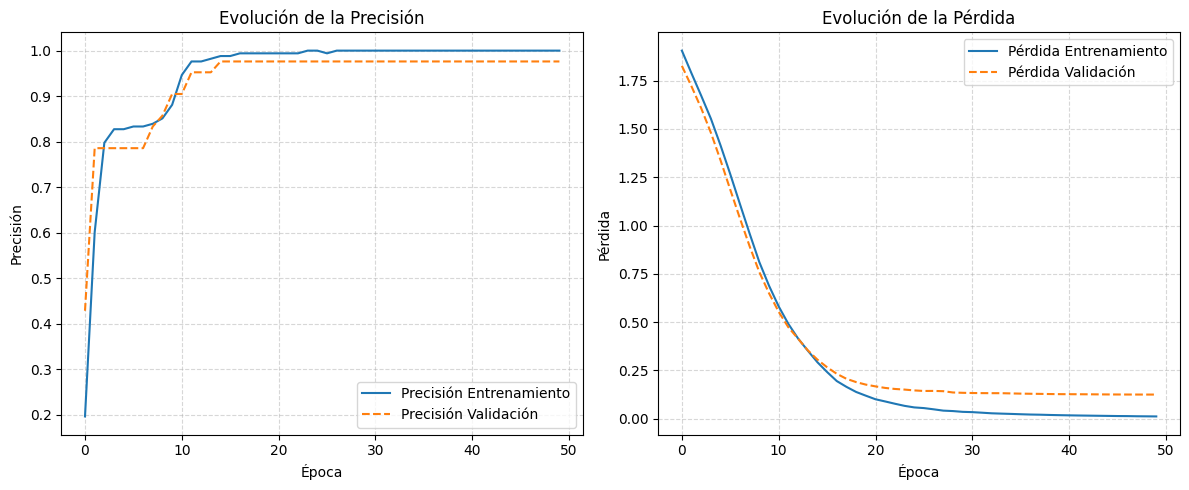

1/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/stepWARNING:tensorflow:6 out of the last 16 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x000002552E2EFD00> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


2/2 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step


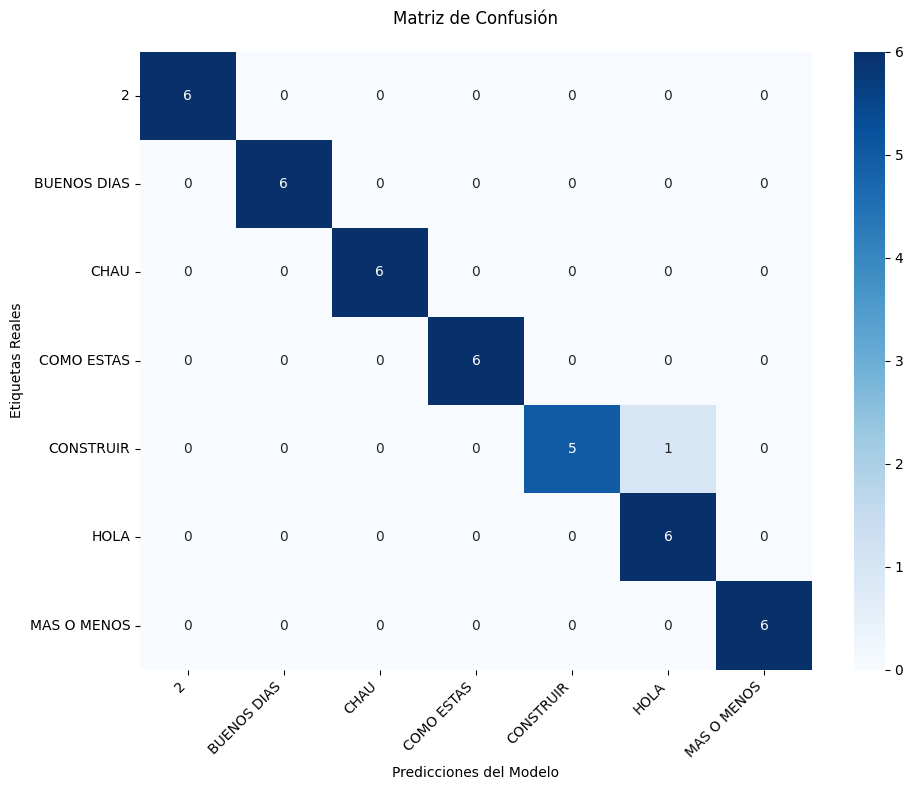


Reporte de Clasificación:
              precision    recall  f1-score   support

           2      1.000     1.000     1.000         6
 BUENOS DIAS      1.000     1.000     1.000         6
        CHAU      1.000     1.000     1.000         6
  COMO ESTAS      1.000     1.000     1.000         6
   CONSTRUIR      1.000     0.833     0.909         6
        HOLA      0.857     1.000     0.923         6
 MAS O MENOS      1.000     1.000     1.000         6

    accuracy                          0.976        42
   macro avg      0.980     0.976     0.976        42
weighted avg      0.980     0.976     0.976        42


Modelo guardado en gesture_model_me_10_90_pruebas_3.h5
INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpltgn4xmj\assets


INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpltgn4xmj\assets


Saved artifact at 'C:\Users\juanp\AppData\Local\Temp\tmpltgn4xmj'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 90, 126), dtype=tf.float32, name='keras_tensor_34')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2564714007360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2564946620864: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565034372160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161822064: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161822240: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161826992: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161825056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161823472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161822592: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565161820304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  256516

INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpu7u24ih4\assets


INFO:tensorflow:Assets written to: C:\Users\juanp\AppData\Local\Temp\tmpu7u24ih4\assets


Saved artifact at 'C:\Users\juanp\AppData\Local\Temp\tmpu7u24ih4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 90, 126), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2565263401808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263406736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263407792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263332752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263336272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263327824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263335040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263335920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263338032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2565263340144: TensorSpec(shape=(), dtype=tf.resource, name=None)
  25652633

In [41]:
if __name__ == "__main__":
    main()
    